In [1]:
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from tqdm import tqdm

# Data Paths

In [2]:
data_directories = list(Path('.').glob('./data_original/*/'))
data_directories = sorted(list(filter(lambda path: path.is_dir(), data_directories)))
data_directories

[PosixPath('data_original/190620'),
 PosixPath('data_original/190701'),
 PosixPath('data_original/190716'),
 PosixPath('data_original/190725'),
 PosixPath('data_original/190812'),
 PosixPath('data_original/190923'),
 PosixPath('data_original/190930')]

In [3]:
data_dir = data_directories[0]
data_dir

PosixPath('data_original/190620')

In [4]:
rtc_file = list(data_dir.glob('./*.rtc'))[0]
rtc_file

PosixPath('data_original/190620/gulfco_27802_19038_011_190620_L090_CX_129A_03.rtc')

In [5]:
hgt_file = list(data_dir.glob('./*.hgt'))[0]
hgt_file

PosixPath('data_original/190620/gulfco_27802_19038_011_190620_L090_CX_129A_03.hgt')

In [6]:
ann_file = list(data_dir.glob('./*.ann'))[0]
ann_file

PosixPath('data_original/190620/gulfco_27802_19038_011_190620_L090_CX_129A_03.ann')

In [7]:
grd_files = sorted(list(data_dir.glob('./*.grd')))
grd_files

[PosixPath('data_original/190620/gulfco_27802_19038_011_190620_L090HHHH_CX_129A_03.grd'),
 PosixPath('data_original/190620/gulfco_27802_19038_011_190620_L090HVHV_CX_129A_03.grd'),
 PosixPath('data_original/190620/gulfco_27802_19038_011_190620_L090VVVV_CX_129A_03.grd')]

# Exploration of Data

In [8]:
def format_annotation_file(ann_file):
    
    with open(ann_file) as f:
        lines = f.readlines()
    
    # Remove Full Line Comments and new lines
    lines = list(filter(lambda x: (x[0] != ';') and (x != '\n'), lines))

    # Remove Extra white space
    lines = list(map(lambda x: x.strip(), lines))

    # There is a rougue empty line so we remove
    lines = list(filter(lambda x: len(x) != 0, lines))

    # Remove trailing line comments
    lines = list(map(lambda x: x.split(';')[0], lines))

    def format_entry(line):
        if '(' in line:
            key = line.split('(')[0].strip()
        else:
            key = line.split('=')[0].strip()

        value = line.split('=')[1].strip()
        return key, value
    
    temp = [format_entry(line) for line in lines]
    annotation_file_data = {t[0]: t[1] for t in temp}
    return annotation_file_data

In [9]:
annotation_file_data = format_annotation_file(ann_file)
annotation_file_data

{'UAVSAR PolSAR Annotation File Version Number': '2.4',
 'Site Description': 'Mike Island',
 'URL': 'http://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName',
 'slcHH': 'gulfco_27802_19038_011_190620_L090HH_CX_129A_03.slc',
 'slcHV': 'gulfco_27802_19038_011_190620_L090HV_CX_129A_03.slc',
 'slcVH': 'gulfco_27802_19038_011_190620_L090VH_CX_129A_03.slc',
 'slcVV': 'gulfco_27802_19038_011_190620_L090VV_CX_129A_03.slc',
 'mlcHHHH': 'gulfco_27802_19038_011_190620_L090HHHH_CX_129A_03.mlc',
 'mlcHVHV': 'gulfco_27802_19038_011_190620_L090HVHV_CX_129A_03.mlc',
 'mlcVVVV': 'gulfco_27802_19038_011_190620_L090VVVV_CX_129A_03.mlc',
 'mlcHHHV': 'gulfco_27802_19038_011_190620_L090HHHV_CX_129A_03.mlc',
 'mlcHHVV': 'gulfco_27802_19038_011_190620_L090HHVV_CX_129A_03.mlc',
 'mlcHVVV': 'gulfco_27802_19038_011_190620_L090HVVV_CX_129A_03.mlc',
 'grdHHHH': 'gulfco_27802_19038_011_190620_L090HHHH_CX_129A_03.grd',
 'grdHVHV': 'gulfco_27802_19038_011_190620_L090HVHV_CX_129A_03.grd',
 'grdVVVV': 'gulfco_27802_19038

In [10]:
ul_col_address = float(annotation_file_data['hgt.col_addr']) # 'Approximate Upper Left Latitude'])
ul_row_address = float(annotation_file_data['hgt.row_addr']) #Approximate Upper Left Longitude'])

height = int(annotation_file_data['hgt.set_rows'])
dy = float(annotation_file_data['hgt.row_mult'])

width = int(annotation_file_data['hgt.set_cols'])
dx = float(annotation_file_data['hgt.col_mult'])
print(ul_col_address,ul_row_address,  height, width, dx, dy)

-91.7388 29.6182 3332 9745 0.0001 -0.0001


In [11]:
transform = rasterio.transform.from_origin(ul_col_address, ul_row_address, dx, -dy)
transform

Affine(0.0001, 0.0, -91.7388,
       0.0, -0.0001, 29.6182)

In [12]:
transform_t = rasterio.transform.from_origin(ul_col_address - dx/2, ul_row_address - dy/2, dx, -dy)
transform_t

Affine(0.0001, 0.0, -91.73885,
       0.0, -0.0001, 29.618250000000003)

In [13]:
profile_from_ann = {'driver': 'GTiff',
                    'dtype': 'float32', 
                    'nodata': np.nan, 
                    'width': width, 
                    'height': height, 
                    'count': 1, 
                    'crs': {'init': 'epsg:4326'}, 
                    'transform': transform_t,
                    'tiled': False, 
                    'interleave': 'band'}

In [14]:
Y = np.memmap(rtc_file, 
              shape=(height, width),
              dtype='float32', 
              mode='c'
         )

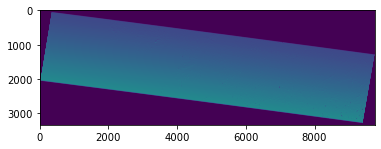

In [15]:
plt.imshow(Y, vmin=0)

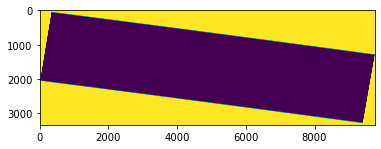

In [16]:
plt.imshow(Y == 0)

In [17]:
X = np.memmap(grd_files[0], 
              shape=(height, width),
              dtype='float32', 
              mode='c'
              )

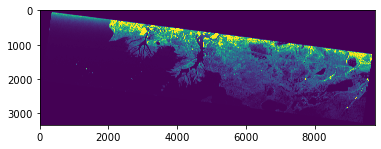

In [18]:
plt.imshow(X, vmin=0, vmax=.55)

# Automate

In [19]:
def get_uavsar_profile(ann_file_path):
    annotation_file_data = format_annotation_file(ann_file_path)
    
    ul_col_address = float(annotation_file_data['hgt.col_addr']) # 'Approximate Upper Left Latitude'])
    ul_row_address = float(annotation_file_data['hgt.row_addr']) #Approximate Upper Left Longitude'])

    height = int(annotation_file_data['hgt.set_rows'])
    dy = float(annotation_file_data['hgt.row_mult'])

    width = int(annotation_file_data['hgt.set_cols'])
    dx = float(annotation_file_data['hgt.col_mult'])
    
    transform_t = rasterio.transform.from_origin(ul_col_address - dx/2, ul_row_address - dy/2, dx, -dy)

    profile_from_ann = {'driver': 'GTiff',
                    'dtype': 'float32', 
                    'nodata': np.nan, 
                    'width': width, 
                    'height': height, 
                    'count': 1, 
                    'crs': {'init': 'epsg:4326'}, 
                    'transform': transform_t,
                    'tiled': False, 
                    'interleave': 'band'}
    
    return profile_from_ann

def write_uavsar_geotiff(data_directory):
    ann_file_path = list(data_directory.glob('./*.ann'))[0]
    rtc_file_path = list(data_directory.glob('./*.rtc'))[0]
    
    grd_file_paths = sorted(list(data_directory.glob('./*.grd')))
    hgt_file_paths = list(data_directory.glob('./*.hgt'))
    # There should only be one DEM
    assert(len(hgt_file_paths) == 1)
    
    dest_directory = Path('data_original_tiff')/data_directory.name
    dest_directory.mkdir(exist_ok=True, parents=True)
    
    uavsar_profile = get_uavsar_profile(ann_file_path)
    
    def open_one(path):
        height, width = (uavsar_profile['height'], 
                         uavsar_profile['width'])
        X = np.memmap(path, 
                      shape=(height, width),
                      dtype='float32', 
                      mode='c'
                     )
        return X
    
    rtc = open_one(rtc_file_path)
    
    def write_one(X, dest_path):
        with rasterio.open(dest_path, 'w', **uavsar_profile) as ds:
            ds.write(X, 1)
        return dest_path
            
    def write_tiff(path, dem=False):
        X = open_one(path)
        if not dem:
            X = rtc * X
            dest_path = dest_directory/(path.name[:-4] + '.tif')
        else:
            dest_path = dest_directory/(path.name[:-4] + '_dem.tif')

        mask = (X == 0)
        X[mask] = np.nan
        dest_path = write_one(X, dest_path)
        return dest_path
    
    write_tiff_dem = lambda path: write_tiff(path, dem=True)
    
    dest_path_grd = list(map(write_tiff, tqdm(grd_file_paths, desc='Backscatter')))
    dest_path_hgt = list(map(write_tiff_dem, tqdm(hgt_file_paths, desc='DEM')))
    
    return dest_path_grd + dest_path_hgt

In [20]:
list(map(write_uavsar_geotiff, tqdm(data_directories, desc='Data Directories')))

Backscatter: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

Backscatter: 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

Backscatter: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

Backscatter: 100%|██████████| 3/3 [00:03<00:00,  1.31s/it]

Backscatter: 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]

Backscatter: 100%|██████████| 3/3 [00:04<00:00,  1.34s/it]

Backscatter: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]

Data Directories: 100%|██████████| 7/7 [00:30<00:00,  4.34s/it]


[[PosixPath('data_original_tiff/190620/gulfco_27802_19038_011_190620_L090HHHH_CX_129A_03.tif'),
  PosixPath('data_original_tiff/190620/gulfco_27802_19038_011_190620_L090HVHV_CX_129A_03.tif'),
  PosixPath('data_original_tiff/190620/gulfco_27802_19038_011_190620_L090VVVV_CX_129A_03.tif'),
  PosixPath('data_original_tiff/190620/gulfco_27802_19038_011_190620_L090_CX_129A_03_dem.tif')],
 [PosixPath('data_original_tiff/190701/gulfco_27802_19043_030_190701_L090HHHH_CX_129A_02.tif'),
  PosixPath('data_original_tiff/190701/gulfco_27802_19043_030_190701_L090HVHV_CX_129A_02.tif'),
  PosixPath('data_original_tiff/190701/gulfco_27802_19043_030_190701_L090VVVV_CX_129A_02.tif'),
  PosixPath('data_original_tiff/190701/gulfco_27802_19043_030_190701_L090_CX_129A_02_dem.tif')],
 [PosixPath('data_original_tiff/190716/gulfco_27802_19048_007_190716_L090HHHH_CX_129A_03.tif'),
  PosixPath('data_original_tiff/190716/gulfco_27802_19048_007_190716_L090HVHV_CX_129A_03.tif'),
  PosixPath('data_original_tiff/190716